In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor

In [2]:
pre = pd.read_csv('machine_data.csv')
pre

,VendorName,ModelName,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
0,adviser,32/60,125,256,6000,256,16,128,198
1,amdahl,470v/7,29,8000,32000,32,8,32,269
2,amdahl,470v/7a,29,8000,32000,32,8,32,220
3,amdahl,470v/7b,29,8000,32000,32,8,32,172
4,amdahl,470v/7c,29,8000,16000,32,8,16,132
...,...,...,...,...,...,...,...,...,...
204,sperry,Aug-80,124,1000,8000,0,1,8,42
205,sperry,90/80-model-3,98,1000,8000,32,2,8,46
206,sratus,32,125,2000,8000,0,2,14,52
207,wang,vs-100,480,512,8000,32,0,0,67


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

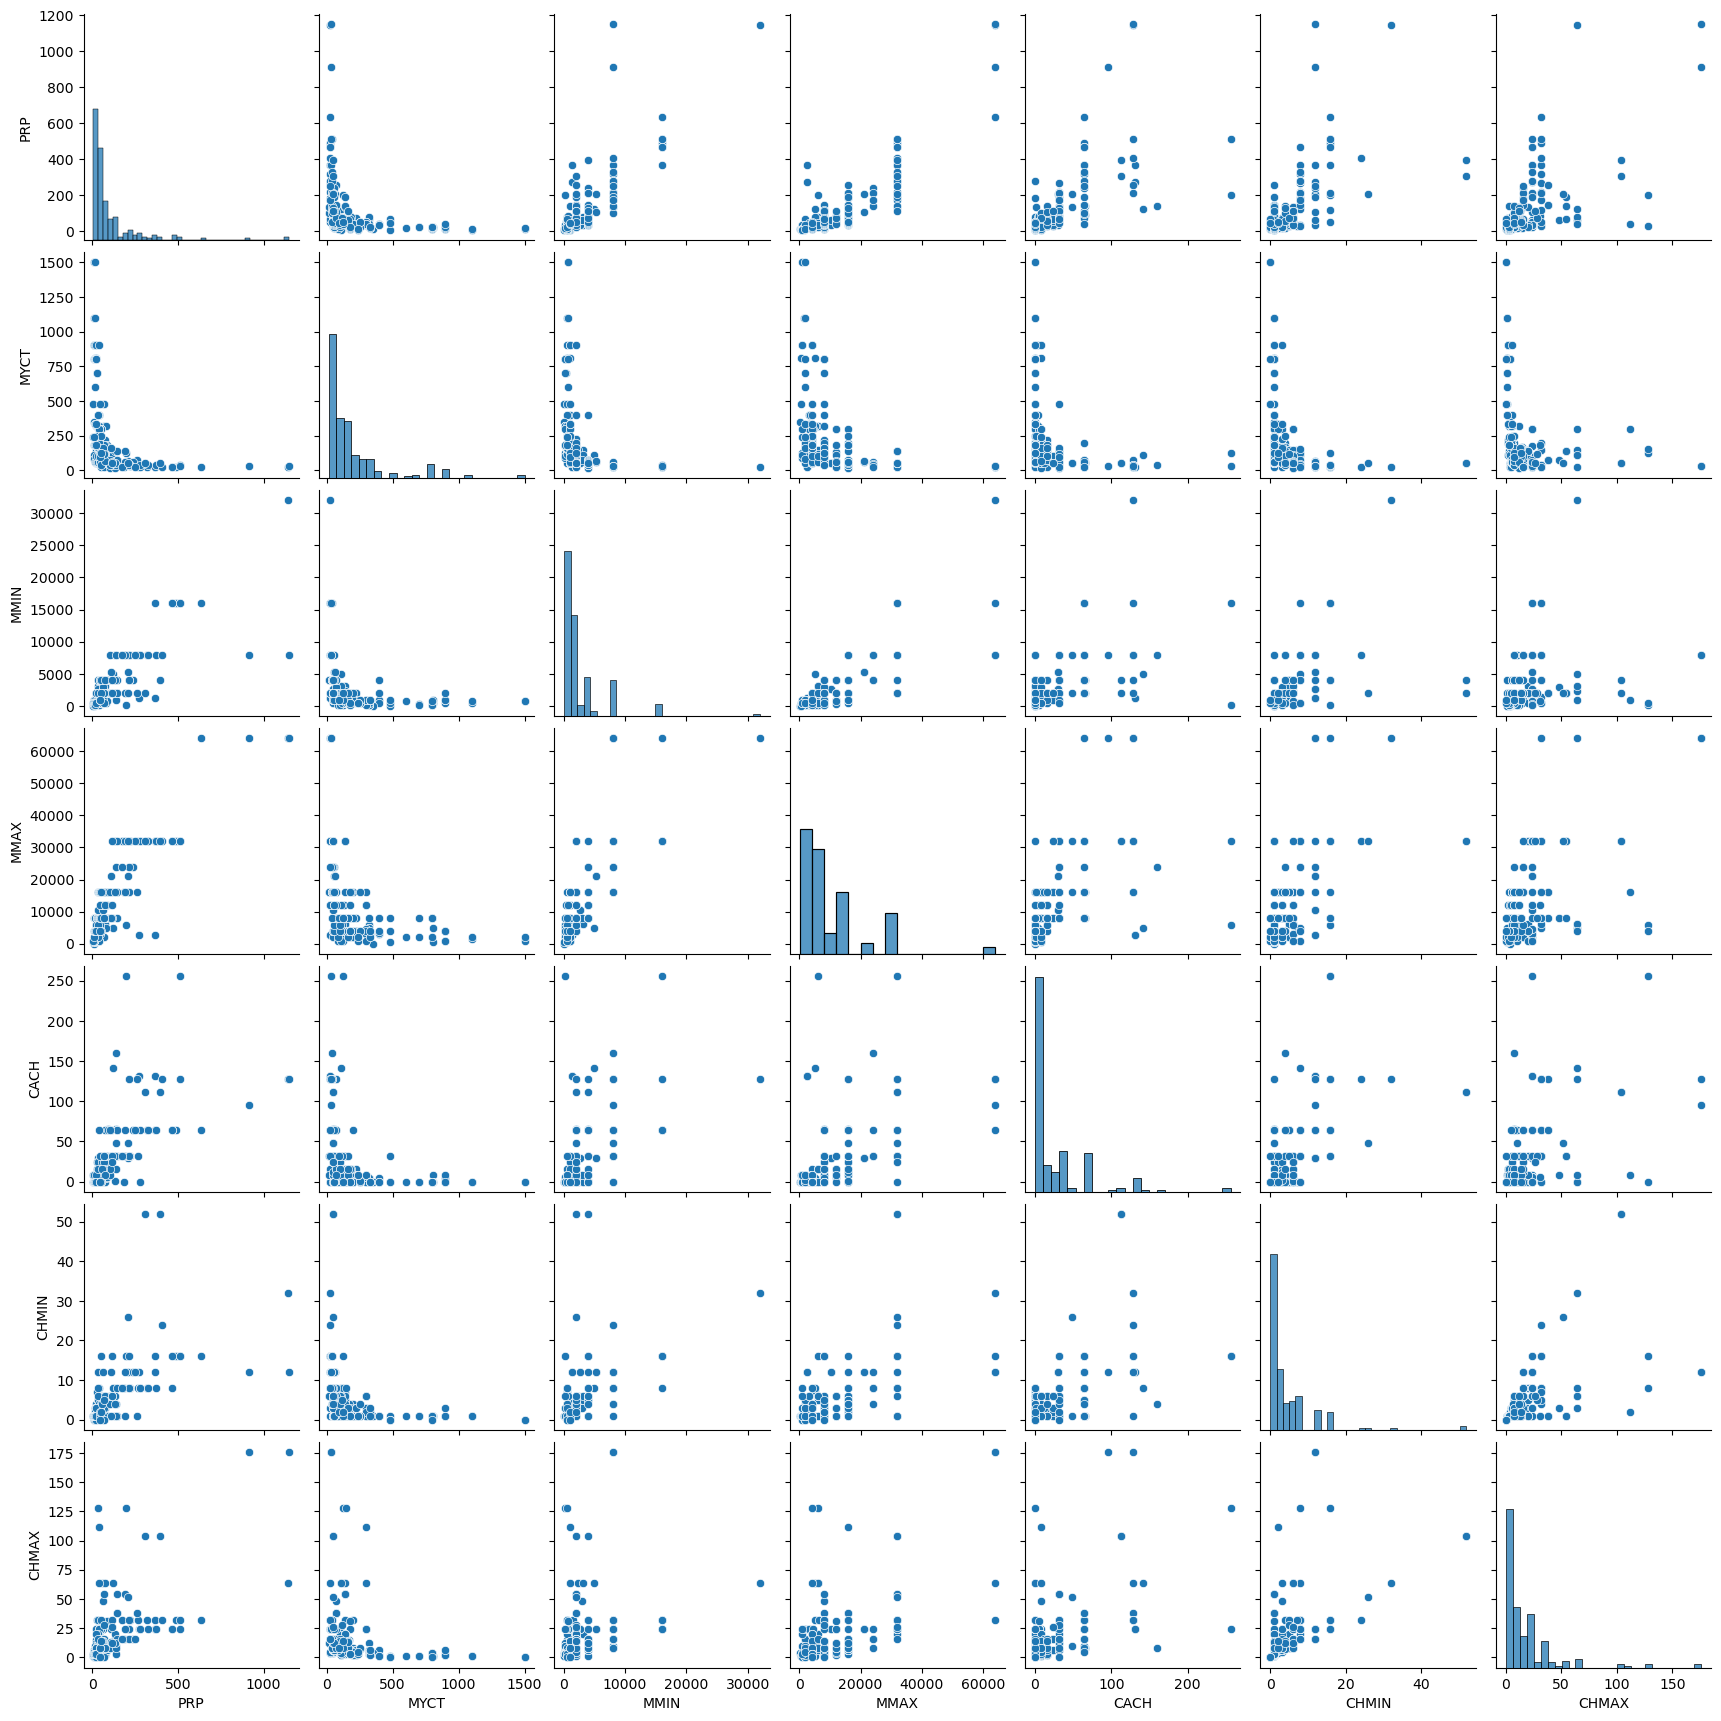

In [3]:
dum = pd.get_dummies(pre.VendorName, prefix='c', dtype=float)
pre = pd.concat([pre.drop('VendorName', axis=1), dum], axis =1)

dum = pd.get_dummies(pre['ModelName'], prefix='s',  dtype=float)
pre = pd.concat([pre.drop('ModelName', axis=1), dum], axis =1)
pre.head()


result = pre.corr()['PRP']

result = np.abs(result)

result.sort_values(ascending = False)

features = ['PRP', 'MYCT', 'MMIN','MMAX', 'CACH', 'CHMIN', 'CHMAX']

sns.pairplot(pre[features])
plt.show()

In [4]:
num_features = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']

X = pre[num_features]
y = pre['PRP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 21)


In [5]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
])
# 개별 모델 정의
models = [('lr', LinearRegression()), ('sgd', SGDRegressor()),]

# 앙상블 모델 정의
ensemble = VotingRegressor(estimators= models)

# 모델 파이프라인 생성
model_pipline = Pipeline(steps=[
    ('preprocessor',preprocessor), 
    ('ensemble', ensemble),
])

# 하이퍼파라미터 튜닝
params_grid = {
    "ensemble__sgd__alpha" : [0.0001, 0.1, 1.0],
    "ensemble__sgd__max_iter" : [1000, 2000, 3000],
}

# GridSearchCV 설정 및 모델 학습
grid_search = GridSearchCV(model_pipline, params_grid, cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True )
# grid_search_mae = GridSearchCV(model_pipline, params_grid, cv = 5, scoring = 'neg_mean_absolute_error', return_train_score = True )
# grid_search_r2 = GridSearchCV(model_pipline, params_grid, cv = 5, scoring = 'r2', return_train_score = True )
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MYCT',
                                                                          'MMIN',
                                                                          'MMAX',
                                                                          'CACH',
                                                                          'CHMIN',
                                                                          'CHMAX'])])),
                                       ('ensemble',
                                        VotingRegressor(estimators=[('lr',
                                                                     LinearRegression()),
                                                                    ('sgd',
                                                                     SGDRegressor())]))]),
             param_grid={'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
                         'ensemble__sgd__max_iter': [1000, 2000, 3000]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [6]:
print(f"Best parameters : {grid_search.best_params_}")

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


Best parameters : {'ensemble__sgd__alpha': 1.0, 'ensemble__sgd__max_iter': 1000}


MSE: 7008.18226524543, MAE:44.20496992615993, R^2:0.8661557415523038


Text(0.5, 1.0, 'PRP')

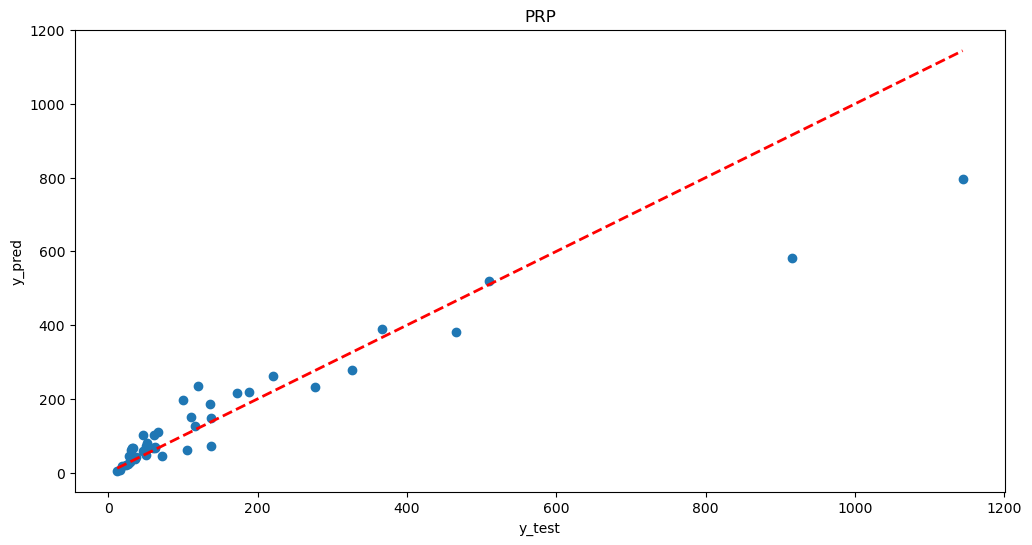

In [7]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, MAE:{mae}, R^2:{r2}")

plt.figure(figsize=(12,6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("PRP")

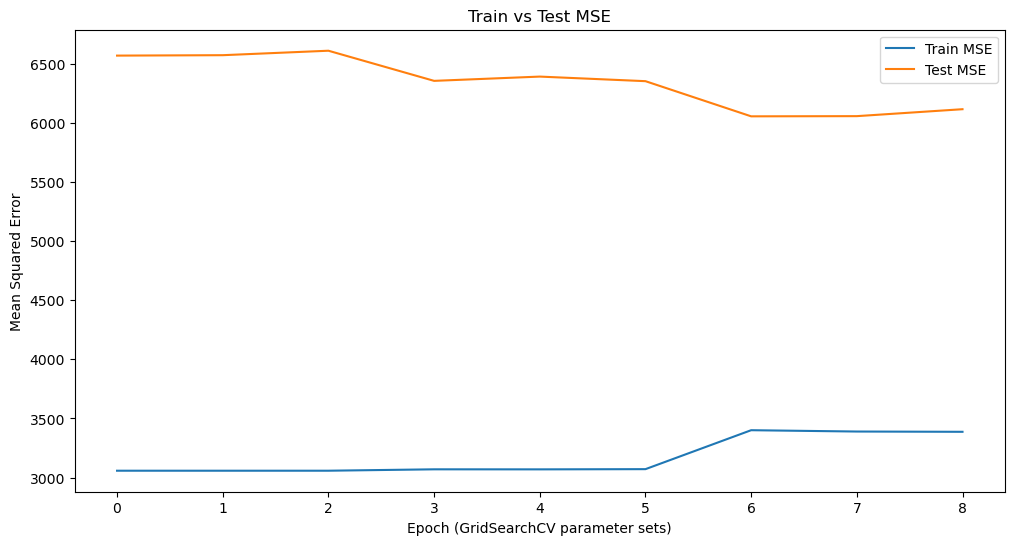

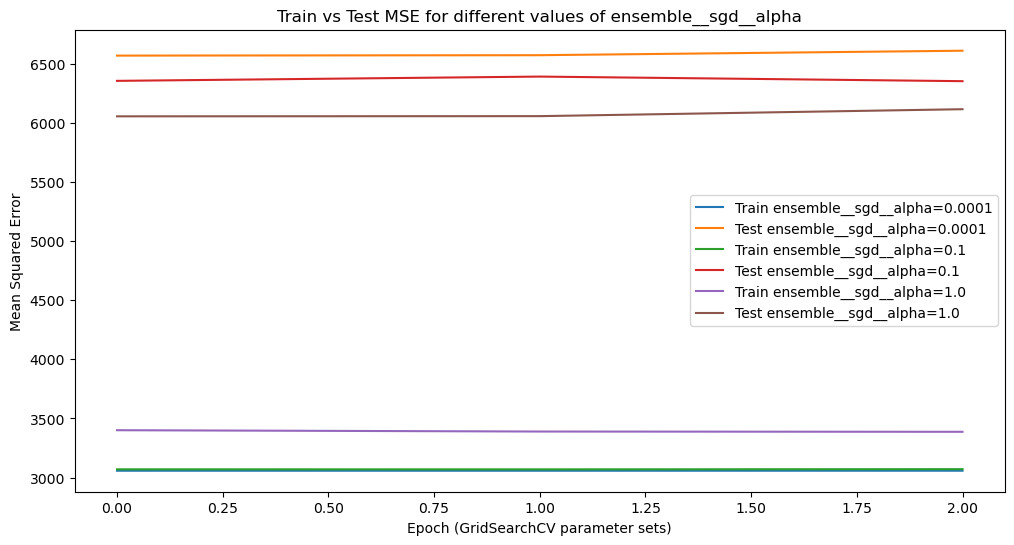

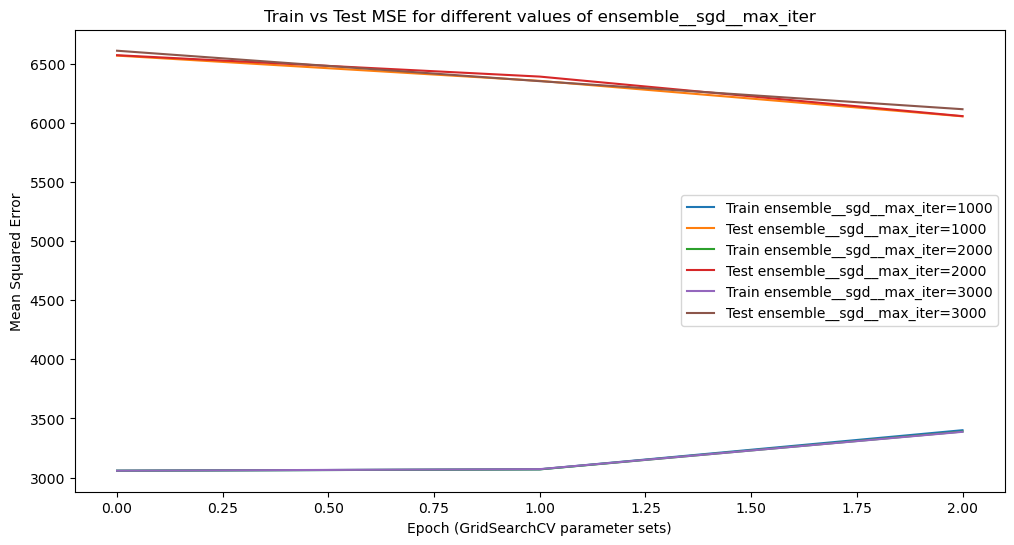

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


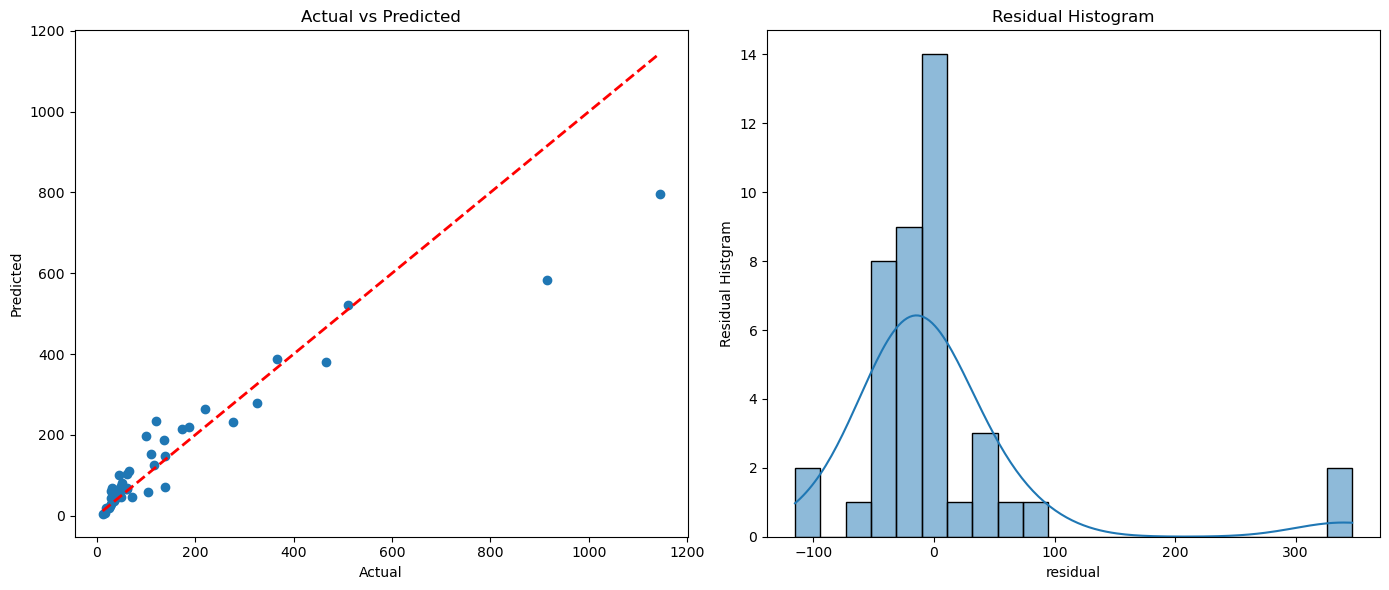

In [8]:
# GridSearchCV 결과 분석
results = pd.DataFrame(grid_search.cv_results_)
results.columns
# 에폭을 X축으로, 훈련 점수 및 테스트 점수 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(len(results['mean_train_score'])), -results['mean_train_score'], label='Train MSE')
plt.plot(range(len(results['mean_test_score'])), -results['mean_test_score'], label='Test MSE')
plt.xlabel('Epoch (GridSearchCV parameter sets)')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Test MSE')
plt.legend()
plt.show()

# 더 많은 파라미터에 대한 시각화
for param in params_grid:
    plt.figure(figsize=(12, 6))
    for value in results['param_' + param].unique():
        subset = results[results['param_' + param] == value]
        plt.plot(range(len(subset)), -subset['mean_train_score'], label=f'Train {param}={value}')
        plt.plot(range(len(subset)), -subset['mean_test_score'], label=f'Test {param}={value}')
    plt.xlabel('Epoch (GridSearchCV parameter sets)')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Train vs Test MSE for different values of {param}')
    plt.legend()
    plt.show()


plt.figure(figsize=(14,6))
# 실제 vs 예측 비교
plt.subplot(1,2,1) # 1행 1열
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel("Predicted")
plt.title('Actual vs Predicted')

# 잔차 히스트그램
plt.subplot(1,2,2) # 1행 2열
sns.histplot(y_test - y_pred, kde=True)
plt.xlabel('residual')
plt.ylabel('Residual Histogram')
plt.title('Residual Histogram')
plt.tight_layout()
plt.show()